# Predicting Bitcoin Price Using LSTM

## Faizan Hameed

### 1-Downloading Dataset in Google Drive

In [472]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [473]:
#Run only 1st time
#import os
#os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"

In [474]:
#changing the working directory
%cd /content/gdrive/My Drive/Kaggle

/content/gdrive/My Drive/Kaggle


In [475]:
#Check the present working directory
import os
os.getcwd() 


'/content/gdrive/My Drive/Kaggle'

In [476]:
#Run this cell only 1st time to download the dataset in spacified directory 
# Copy the API command from Kaggle Dataset and paste(using !) to download the data
#!kaggle datasets download -d mczielinski/bitcoin-historical-data

In [477]:
#check the content in our directory
!ls

BC_Data.csv  coin_Bitcoin.csv  final_model.h5  kaggle.json  model_final.json


In [478]:
#Run only once to unzip the Dataset
#unzipping the zip files and deleting the zip files
#!unzip \*.zip  && rm *.zip

### 2-Importing Libraries 

In [479]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dropout, LeakyReLU,Dense
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.callbacks import EarlyStopping
from keras.losses import MeanSquaredError
from keras.optimizers import Adam
from keras.losses import MeanAbsoluteError
from keras.models import model_from_json
from scipy import stats
from statsmodels.tsa.stattools import adfuller
%matplotlib inline

### 3- Importing dataset

In [480]:
data_frame=pd.read_csv('BC_Data.csv')
print('1st 5 rows')
data_frame.head(5)




1st 5 rows


,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
1,1325317980,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1325318040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1325318100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1325318160,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [481]:
d_frame=data_frame[600000:] # we are selecting data after 600000 rows. Before it the data have not much information

In [482]:
d_frame.shape # No of rows and columns in this dataframe 

(4257377, 8)

### 4-Data Cleaning

We are going to convert time stemp to date.

In [483]:
d_frame["Timestamp"]=pd.to_datetime(d_frame['Timestamp'],unit='s').dt.date #We converted in time stamp format
#d_frame = d_frame.set_index(['Timestamp']) #If we want to set "Timestamp" as index.
d_frame.head(5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
600000,2013-02-19,29.39,29.39,29.39,29.39,1.0,29.39,29.39
600001,2013-02-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN
600002,2013-02-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN
600003,2013-02-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN
600004,2013-02-19,29.39,29.39,29.39,29.39,2.0,58.78,29.39


In [484]:
print('last 5 rows')
d_frame.tail(5)

last 5 rows


,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
4857372,2021-03-30,58714.31,58714.31,58686.00,58686.00,1.384487,81259.372187,58692.753339
4857373,2021-03-30,58683.97,58693.43,58683.97,58685.81,7.294848,428158.146640,58693.226508
4857374,2021-03-30,58693.43,58723.84,58693.43,58723.84,1.705682,100117.070370,58696.198496
4857375,2021-03-30,58742.18,58770.38,58742.18,58760.59,0.720415,42332.958633,58761.866202
4857376,2021-03-31,58767.75,58778.18,58755.97,58778.18,2.712831,159417.751000,58764.349363


We can see that our data is upto date.

In [485]:
d_frame.shape # No of rows and columns in this dataframe 

(4257377, 8)

Now we are going to remove all un necessary columns.

In [486]:
d_frame.columns

Index(['Timestamp', 'Open', 'High', 'Low', 'Close', 'Volume_(BTC)',
       'Volume_(Currency)', 'Weighted_Price'],
      dtype='object')

In [487]:
d_frame.drop(['Open',"High",'Low','Close'] , inplace=True, axis=1)
d_frame

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,Timestamp,Volume_(BTC),Volume_(Currency),Weighted_Price
600000,2013-02-19,1.000000,29.390000,29.390000
600001,2013-02-19,NaN,NaN,NaN
600002,2013-02-19,NaN,NaN,NaN
600003,2013-02-19,NaN,NaN,NaN
600004,2013-02-19,2.000000,58.780000,29.390000
...,...,...,...,...
4857372,2021-03-30,1.384487,81259.372187,58692.753339
4857373,2021-03-30,7.294848,428158.146640,58693.226508
4857374,2021-03-30,1.705682,100117.070370,58696.198496
4857375,2021-03-30,0.720415,42332.958633,58761.866202


In [488]:
#Renaming Column "Weighted_Price"
d_frame.rename(columns={'Weighted_Price': 'Bitcoin_Price'}, inplace=True)
d_frame.head(10)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,Timestamp,Volume_(BTC),Volume_(Currency),Bitcoin_Price
600000,2013-02-19,1.00000,29.390000,29.39
600001,2013-02-19,NaN,NaN,NaN
600002,2013-02-19,NaN,NaN,NaN
600003,2013-02-19,NaN,NaN,NaN
600004,2013-02-19,2.00000,58.780000,29.39
600005,2013-02-19,NaN,NaN,NaN
600006,2013-02-19,34.48439,1013.496222,29.39
600007,2013-02-19,NaN,NaN,NaN
600008,2013-02-20,159.60000,4690.644000,29.39
600009,2013-02-20,NaN,NaN,NaN


In [489]:
d_frame.shape

(4257377, 4)

In [490]:
# We want to replace missing values i.e "?" to Python's default missing value marker "NaN"
d_frame.replace("?", np.nan, inplace = True)
d_frame.head(10)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4389: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


,Timestamp,Volume_(BTC),Volume_(Currency),Bitcoin_Price
600000,2013-02-19,1.00000,29.390000,29.39
600001,2013-02-19,NaN,NaN,NaN
600002,2013-02-19,NaN,NaN,NaN
600003,2013-02-19,NaN,NaN,NaN
600004,2013-02-19,2.00000,58.780000,29.39
600005,2013-02-19,NaN,NaN,NaN
600006,2013-02-19,34.48439,1013.496222,29.39
600007,2013-02-19,NaN,NaN,NaN
600008,2013-02-20,159.60000,4690.644000,29.39
600009,2013-02-20,NaN,NaN,NaN


In [491]:
#After converting to default now detecting missing data(we can use .isnull()
#or .notnull() method)
#True" stands for missing value, while "False" stands for not missing value.
missing_values = d_frame.isnull()
missing_values.head(10)

,Timestamp,Volume_(BTC),Volume_(Currency),Bitcoin_Price
600000,False,False,False,False
600001,False,True,True,True
600002,False,True,True,True
600003,False,True,True,True
600004,False,False,False,False
600005,False,True,True,True
600006,False,False,False,False
600007,False,True,True,True
600008,False,False,False,False
600009,False,True,True,True


In [492]:
# Checking the missing values in each column
for column in missing_values.columns.values.tolist():
    print(column)
    print (missing_values[column].value_counts())
    print("") 

Timestamp
False    4257377
Name: Timestamp, dtype: int64

Volume_(BTC)
False    3578367
True      679010
Name: Volume_(BTC), dtype: int64

Volume_(Currency)
False    3578367
True      679010
Name: Volume_(Currency), dtype: int64

Bitcoin_Price
False    3578367
True      679010
Name: Bitcoin_Price, dtype: int64



Before adjusting the missing values in our data i want to explore data further.

### 5-Exploritory Data Analysis

In [493]:
d_frame.index

RangeIndex(start=600000, stop=4857377, step=1)

In [494]:
d_frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4257377 entries, 600000 to 4857376
Data columns (total 4 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Timestamp          object 
 1   Volume_(BTC)       float64
 2   Volume_(Currency)  float64
 3   Bitcoin_Price      float64
dtypes: float64(3), object(1)
memory usage: 129.9+ MB


In [495]:
print(d_frame.dtypes)

Timestamp             object
Volume_(BTC)         float64
Volume_(Currency)    float64
Bitcoin_Price        float64
dtype: object


In [496]:
corr=d_frame.corr()
corr

,Volume_(BTC),Volume_(Currency),Bitcoin_Price
Volume_(BTC),1.000000,0.359853,-0.050169
Volume_(Currency),0.359853,1.000000,0.343089
Bitcoin_Price,-0.050169,0.343089,1.000000


"Volume_(BTC)" have very weak correlation with "Bitcoin_Price".

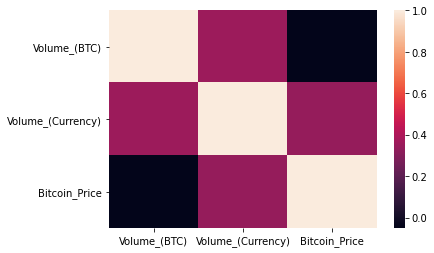

In [497]:
sns.heatmap(corr)

(0.0, 64608.21658939999)

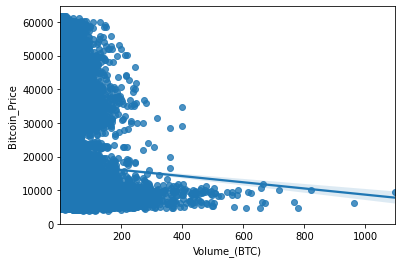

In [498]:
#checking the linear relationship b/w "Volume_(BTC)" & "Bitcoin_Price"

d_select = d_frame.loc[d_frame['Timestamp'] > pd.to_datetime('2020-01-01')] #The plot takes so much time so we selected a slot of data from whole d_frame""


sns.regplot(x="Volume_(BTC)", y="Bitcoin_Price", data=d_select)# We can't understand any relationship between these two variables
plt.ylim(0,)

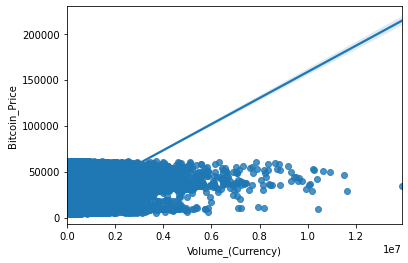

In [499]:
#checking the linear relationship b/w "Volume_(Currency)" & "Bitcoin_Price"
sns.regplot(x="Volume_(Currency)", y="Bitcoin_Price", data=d_select) 


We are going to drop these two columns(Volumre_(Currency),Volume_(BTC)). If we want to analyse further to check them as a candidate for features than P-value is the probability value which shows that the correlation between the two 
variables is statistically significant. Normally, we choose a significance level of 0.05 i.e P-value < 0.05. We can also check "P_Value" for selecting different features (after adjusting NAN values in our data) with the help of following code that i have commented.

In [500]:
#Checking p-value of "Volume_(BTC)"
#pearson_coef, p_value = stats.pearsonr(d_frame['Volume_(BTC)'], d_frame['Bitcoin_Price'])
#print("The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P =", p_value)
#if p_value < 0.05:
#  print('Correlation is significant')
#else:
#  print('Correlation is not significant')

In [501]:
#Checking p-value of "Volume_(Currency)"
#pearson_coef, p_value = stats.pearsonr(d_frame['Volume_(Currency)'], d_frame['Bitcoin_Price'])
#print("The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P =", p_value)
#if p_value < 0.05:
#  print('Correlation is significant')
#else:
#  print('Correlation is not significant')

In [502]:
d_frame.columns

Index(['Timestamp', 'Volume_(BTC)', 'Volume_(Currency)', 'Bitcoin_Price'], dtype='object')

Analysis shows that 'Volume_(BTC) can't use as a feature in training data. Also Volume_(Currency) can effect the predictions.So, we will drop these two columns in future.

There are multiple readings at every day in dataframe so  grouping data w.r.t "Timestamp" and taking the mean of each group.

In [503]:
grouping=d_frame.groupby('Timestamp')
df=grouping['Bitcoin_Price','Volume_(BTC)', 'Volume_(Currency)'].mean()
df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


,Bitcoin_Price,Volume_(BTC),Volume_(Currency)
Timestamp,,,
2013-02-19,29.390000,12.494797,367.222074
2013-02-20,29.685068,14.683499,435.076442
2013-02-21,29.901464,19.867289,594.147644
2013-02-22,30.602213,17.125214,522.445188
2013-02-23,29.034383,15.714830,455.311991
...,...,...,...
2021-03-27,55193.357260,1.823877,100884.732367
2021-03-28,55832.958824,1.447939,80632.115263
2021-03-29,56913.993819,3.732887,213754.555988


In [505]:
df.dtypes

Bitcoin_Price        float64
Volume_(BTC)         float64
Volume_(Currency)    float64
dtype: object

In [506]:
#checking that if there is any missing value. 
df.isnull().values.any()

False

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f9ad98a4bd0>],
      dtype=object)

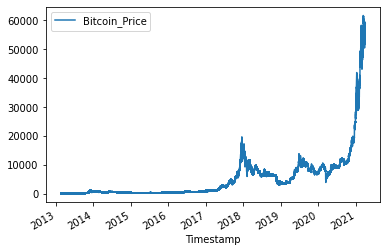

In [507]:
df['Timestamp'] = df.index #reseting "Timestamp" from index to column, only to plot the data w.r.t Timestamp 
d_frame.set_index('Timestamp')[['Bitcoin_Price']].plot(subplots=True) #Before this command it is important to convert into timestamp format because it plot the data w.r.t timestamp. This command is some of the commands that are used to plot time series data.We set the Timestamp as index by using 'Volume_(BTC)' command.

From the last graph it looks like that the data is non-stationary. The stationary data have constant statistical properties like mean, variance and covariance.(Also autocorelation etc). Checking the stationarity of data(Timeseries).

######i) Dickey–Fuller test

In [508]:
#To check wheather our data is stationary or non_stationary we are going to perform Augmented Dickey-Fuller Test
# For this purpose we are defining a function
def stationarity_check(time_series):
  results=adfuller(time_series)
  print("Test_statistics=",results[0],'  P_value=' , results[1], "     Lags_used =",results[2],"   Number of Observation Used =",results[3],"  P_value Statistics=  ",results[4])


In [509]:
#stationarity checking for "Bitcoin_Price"
stationarity_check(df['Bitcoin_Price'])
# "Test_statistics" more negitive mean more likely to be stationary
#If "P_Value" is less than 0.05 than it must be stationary and we will reject our Null Hypothesis

Test_statistics= 5.629931484011256   P_value= 1.0      Lags_used = 26    Number of Observation Used = 2933   P_value Statistics=   {'1%': -3.4325815146212344, '5%': -2.862525935297511, '10%': -2.567294840682737}


We can see that fourth element of our resulted touple gives us the dictionary which contain the critical test statistics. (At second position of this dictionary)We can see that Test_statistics value should be below mentioned value (of key 5%) if we want P_value of 5% or 0.05.

A second Test we can also perform to check the stationarity of our data. Splitting the timeseries into two or more partition and checking the mean and variance of each. 

###### ii) Mean and Variance Difference Test

In [510]:
df.shape


(2960, 4)

In [511]:
#splitting dataframe into two
df1=df[0:410]
df2=df[410:820]

In [512]:
#Checking the mean of df1
df1.mean()

Bitcoin_Price         321.374913
Volume_(BTC)           14.555814
Volume_(Currency)    5253.252448
dtype: float64

In [513]:
#Checking the mean of df2
df2.mean()

Bitcoin_Price         394.197960
Volume_(BTC)           10.945745
Volume_(Currency)    4085.294655
dtype: float64

We can see that both dataframes have different mean values so it has not constant mean in whole dataframe. Now checking the variance.

In [514]:
df1.var()

Bitcoin_Price        9.061587e+04
Volume_(BTC)         1.136058e+02
Volume_(Currency)    5.619117e+07
dtype: float64

In [515]:
df2.var()

Bitcoin_Price        1.883807e+04
Volume_(BTC)         7.224392e+01
Volume_(Currency)    8.306820e+06
dtype: float64

So it is clear that our timeseries is non-stationary. So, first of all we will make it stationary. There are multiple method to convert non-stationary timeseries into stationary form.

1.   Differencing or Seasonal Differencing
2.   Transformation
3.    Rolling Statistics


We are going to use differencing method first.

In [516]:
#We are going to make another column where we can store our difference(Using differencing method)
df['Bitcoin_Price_df'] = df['Bitcoin_Price'] - df['Bitcoin_Price'].shift(1)#"shift(1)" we want to subtract the last value
df['Bitcoin_Price_df'].head(3)



Timestamp
2013-02-19         NaN
2013-02-20    0.295068
2013-02-21    0.216395
Name: Bitcoin_Price_df, dtype: float64

In [517]:
#Removing the NAN values(Because there is no value before first value to make difference so there is a NAN in the beginning)

df.dropna(axis=0, inplace=True)

# reset indexs
#df.reset_index(drop=False, inplace=True)
df.head(5)

,Bitcoin_Price,Volume_(BTC),Volume_(Currency),Timestamp,Bitcoin_Price_df
Timestamp,,,,,
2013-02-20,29.685068,14.683499,435.076442,2013-02-20,0.295068
2013-02-21,29.901464,19.867289,594.147644,2013-02-21,0.216395
2013-02-22,30.602213,17.125214,522.445188,2013-02-22,0.700750
2013-02-23,29.034383,15.714830,455.311991,2013-02-23,-1.567830
2013-02-24,29.752125,9.699863,288.773099,2013-02-24,0.717742


In [518]:
stationarity_check(df['Bitcoin_Price_df'])

Test_statistics= -8.52639557481854   P_value= 1.0663176593501189e-13      Lags_used = 28    Number of Observation Used = 2930   P_value Statistics=   {'1%': -3.4325838014549075, '5%': -2.8625269452952895, '10%': -2.567295378396953}


Data seems to be much batter now.


In [519]:
df.describe()

,Bitcoin_Price,Volume_(BTC),Volume_(Currency),Bitcoin_Price_df
count,2959.000000,2959.000000,2959.000000,2959.000000
mean,5253.290259,9.121097,36244.118547,19.849598
std,8570.474835,7.638068,65822.555689,394.804143
min,29.034383,0.763737,219.747906,-5739.474079
25%,406.683528,4.457301,2939.377941,-12.313185
50%,1137.763090,6.908461,11097.563578,0.908395
75%,7956.063443,11.379304,41214.261707,25.289053
max,60455.844831,95.652602,950995.602917,5487.876405


We can see that our data have many outliers in almost all columns.

In [520]:
df.query('Bitcoin_Price_df	>25.28')# We have used 75% value to check outliers.(in BC_log)

,Bitcoin_Price,Volume_(BTC),Volume_(Currency),Timestamp,Bitcoin_Price_df
Timestamp,,,,,
2013-04-08,182.560329,11.899790,2166.628077,2013-04-08,29.140757
2013-04-09,211.415484,10.478307,2251.332082,2013-04-09,28.855155
2013-04-13,103.400689,14.227255,1444.287247,2013-04-13,26.086947
2013-11-07,283.168363,36.227297,10263.869791,2013-11-07,27.936754
2013-11-08,314.513558,28.340027,9010.498661,2013-11-08,31.345195
...,...,...,...,...,...
2021-03-27,55193.357260,1.823877,100884.732367,2021-03-27,1952.319771
2021-03-28,55832.958824,1.447939,80632.115263,2021-03-28,639.601564
2021-03-29,56913.993819,3.732887,213754.555988,2021-03-29,1081.034995


In [521]:
df.query('Bitcoin_Price_df	<-12.313')# We have used 25% value to check outliers. 

,Bitcoin_Price,Volume_(BTC),Volume_(Currency),Timestamp,Bitcoin_Price_df
Timestamp,,,,,
2013-04-11,124.666168,29.740915,3161.635310,2013-04-11,-82.398628
2013-04-12,77.313743,22.678027,1721.293066,2013-04-12,-47.352425
2013-04-16,65.474750,27.722505,1812.982337,2013-04-16,-25.139685
2013-04-26,134.669592,8.311758,1115.108050,2013-04-26,-15.716975
2013-05-01,128.522075,16.073802,1958.773743,2013-05-01,-13.091941
...,...,...,...,...,...
2021-03-19,58283.547994,2.448563,142768.675307,2021-03-19,-188.569327
2021-03-21,57312.598536,2.523503,144363.205985,2021-03-21,-1467.170850
2021-03-22,56787.148422,4.566736,255685.092495,2021-03-22,-525.450114


In [522]:
df.dtypes

Bitcoin_Price        float64
Volume_(BTC)         float64
Volume_(Currency)    float64
Timestamp             object
Bitcoin_Price_df     float64
dtype: object

In [523]:
df.columns

Index(['Bitcoin_Price', 'Volume_(BTC)', 'Volume_(Currency)', 'Timestamp',
       'Bitcoin_Price_df'],
      dtype='object')

Now we are going to select our input column which is 'Bitcoin_Price_df'

In [524]:
df_in=df[['Bitcoin_Price_df']]  # Time stamp is not included in input dataframe

Standard scaler will not account the outliers so we use "MinMaxScaler"

In [525]:
scaler=MinMaxScaler()
scaled_data=scaler.fit_transform(df_in)
scaled_data #Data is b/w 0 and 1

array([[0.51123096],
       [0.51122395],
       [0.51126709],
       ...,
       [0.60749053],
       [0.63883216],
       [0.54838505]])

In [526]:
features=scaled_data#Same time series is used in features and target data
target=scaled_data

In [527]:
features

array([[0.51123096],
       [0.51122395],
       [0.51126709],
       ...,
       [0.60749053],
       [0.63883216],
       [0.54838505]])

In [528]:
target

array([[0.51123096],
       [0.51122395],
       [0.51126709],
       ...,
       [0.60749053],
       [0.63883216],
       [0.54838505]])

In [529]:
features.shape

(2959, 1)

In [530]:
target.shape

(2959, 1)

In [531]:
# Splitting the Training and Test data
x_train,x_test,y_train,y_test = train_test_split(features,target,test_size=0.009,random_state=42,shuffle=False)

In [532]:
x_train.shape

(2932, 1)

In [533]:
x_test.shape #We wnant to predict the price of Bitcoin in the spam of one month

(27, 1)

In [534]:
y_train.shape

(2932, 1)

In [535]:
y_test.shape

(27, 1)

In [536]:
x_train = np.reshape(x_train, (len(x_train), 1, 1))
x_train.shape

(2932, 1, 1)

In [537]:
x_test = np.reshape(x_test, (len(x_test), 1, 1))
x_test.shape

(27, 1, 1)

### 6- Model Development and Compilation

In [538]:
model = Sequential()
# In following line of code,128 is LSTM output.We set"return_sequences=True" because we require hidden state for each of our input data otherwise it will return
#only one hidden state for all the input data.it is time series data so we need to have hidde state for each and every observation.
model.add(LSTM(128,input_shape=(5,1),return_sequences=True))#note that if we write batch dimension i.e "input_shape=(None,1)" here instead of "input_shape=(5,1)", than the model will be able to process batches of any size.
model.add(LeakyReLU(alpha=0.5))
model.add(LSTM(128, return_sequences=True))
model.add(LeakyReLU(alpha=0.5))
model.add(Dropout(0.3))
model.add(LSTM(64, return_sequences=False))# return only single hidden state. If we want to further use other layers before final layer we can set it equel to true.
model.add(Dropout(0.3))
model.add(tf.keras.layers.Dense(1))
print(model.summary())

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_53 (LSTM)               (None, 5, 128)            66560     
_________________________________________________________________
leaky_re_lu_22 (LeakyReLU)   (None, 5, 128)            0         
_________________________________________________________________
lstm_54 (LSTM)               (None, 5, 128)            131584    
_________________________________________________________________
leaky_re_lu_23 (LeakyReLU)   (None, 5, 128)            0         
_________________________________________________________________
dropout_33 (Dropout)         (None, 5, 128)            0         
_________________________________________________________________
lstm_55 (LSTM)               (None, 64)                49408     
_________________________________________________________________
dropout_34 (Dropout)         (None, 64)              

In [539]:
# Early stopping is if our validation loss is not improving then it will stop the training earlier.it will observe equal to number of iterations equal to 'patience' for validation loss improvement.
#earl_stop=EarlyStopping(monitor="val_loss",patience=5,mode='min')

In [540]:
#Compiling the model
model.compile(loss='mse', optimizer='adam', metrics=['mae'])
#or
#model.compile(loss = MeanSquaredError(), optimizer=Adam(),metrics =[MeanAbsoluteError()])

### 7-Model Training 

In [541]:
epochs=30
batch_size=5
#Training our model
history=model.fit(x_train, y_train, batch_size = batch_size,validation_data=(x_test, y_test), epochs=epochs,shuffle=False)#if we introduce callback above than we have to add "callbacks=earl_stop" here.

Epoch 1/30
587/587 [==============================] - 10s 8ms/step - loss: 0.0404 - mae: 0.1230 - val_loss: 0.0092 - val_mae: 0.0718
Epoch 2/30
587/587 [==============================] - 4s 6ms/step - loss: 0.0020 - mae: 0.0355 - val_loss: 0.0072 - val_mae: 0.0619
Epoch 3/30
587/587 [==============================] - 4s 6ms/step - loss: 0.0017 - mae: 0.0333 - val_loss: 0.0045 - val_mae: 0.0573
Epoch 4/30
587/587 [==============================] - 4s 6ms/step - loss: 0.0012 - mae: 0.0280 - val_loss: 5.1903e-04 - val_mae: 0.0147
Epoch 5/30
587/587 [==============================] - 3s 6ms/step - loss: 9.5546e-04 - mae: 0.0247 - val_loss: 1.0888e-04 - val_mae: 0.0085
Epoch 6/30
587/587 [==============================] - 4s 6ms/step - loss: 6.2789e-04 - mae: 0.0201 - val_loss: 3.0948e-04 - val_mae: 0.0170
Epoch 7/30
587/587 [==============================] - 3s 6ms/step - loss: 4.5698e-04 - mae: 0.0171 - val_loss: 3.7957e-05 - val_mae: 0.0042
Epoch 8/30
587/587 [===========================

In [542]:
#saving the model

#model_json = model.to_json()
#with open("model_final.json", "w") as json_file:
#    json_file.write(model_json)
#model.save_weights("final_model.h5")

### 8-Model Evaluation and Prediction

In [543]:

def plot_learning_curve(history,epoch):
    #plots value of training accuracy and the validation accuracy
    epoch_range=range(1,epoch+1)
    plt.plot(epoch_range,history.history['mae'])
    plt.plot(epoch_range,history.history['val_mae'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train','Val'],loc='upper left')
    plt.show()
    
    #plots the value of training loss and validation accuracy loss
    plt.plot(epoch_range,history.history['loss'])
    plt.plot(epoch_range,history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('')
    plt.xlabel('Epoch')
    plt.legend(['Train','Val'],loc='upper left')

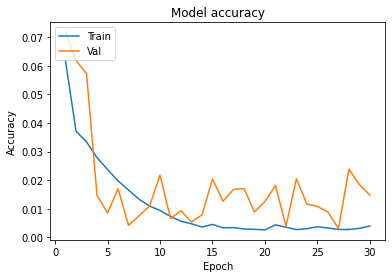

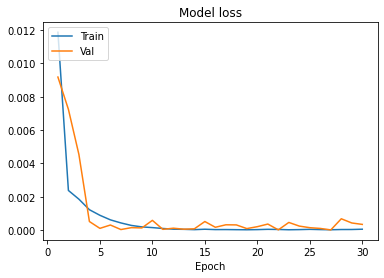

In [544]:
learning_curve = plot_learning_curve(history,epochs)

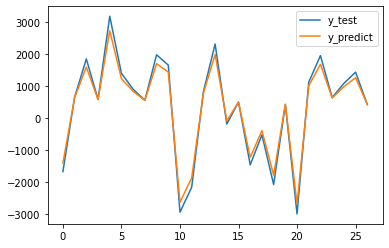

In [545]:
y_pred = model.predict(x_test)
plt.plot(scaler.inverse_transform(y_test.reshape(-1, 1)))
plt.plot(scaler.inverse_transform(y_pred))
plt.legend(['y_test', 'y_predict'])

In [549]:
print('Some Predicted values= ',y_pred[10:20], 'Real values=  ',y_test[10:20])

Some Predicted values=  [[0.27614057]
 [0.34427577]
 [0.5798975 ]
 [0.68812   ]
 [0.50351375]
 [0.5555162 ]
 [0.40124074]
 [0.47611272]
 [0.35170612]
 [0.54955894]] Real values=   [[0.24862177]
 [0.31811106]
 [0.5840814 ]
 [0.71731742]
 [0.49440914]
 [0.55540223]
 [0.3805264 ]
 [0.46440378]
 [0.32560785]
 [0.54866731]]
